In [177]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [178]:
def stock_filter(ticker1, ticker2, data, p_val_treshold, corr_threshold, verbos = False):
    S1 = data[ticker1]
    S2 = data[ticker2]
    corr = S1.corr(S2)
    X = sm.add_constant(S2)
    model = sm.OLS(S1, X).fit()
    residuals = model.resid
    p_value = adfuller(residuals)[1]
    if p_value <= p_val_treshold and corr >= corr_threshold:
        if verbos:
            print(f"{ticker1} {ticker2} pval:{p_value} corr:{corr}")
        return True
    else:
        if verbos:
            print(f"{ticker1} {ticker2} pval:{p_value} corr:{corr}")
        return False

In [179]:
data = pd.read_csv('data/daily_close.csv', index_col=[0])


In [180]:
stock_pairs = list(combinations(data.columns, 2))
n = len(data.columns)
print(n*(n-1)/2)
len(stock_pairs)

1225.0


1225

In [181]:
bool_matrix = pd.DataFrame(np.zeros((50, 50), dtype=bool), columns=data.columns, index=data.columns)

In [182]:
test_data = data.iloc[int(len(data)*0.7):]
train_data = data.iloc[:int(len(data)*0.7)]

In [183]:
list_of_pairs = []
for stock1, stock2 in tqdm.tqdm(stock_pairs):
    bool_matrix.loc[stock1, stock2] = stock_filter(stock1, stock2, test_data, 0.01, 0.9)
    bool_matrix.loc[stock2, stock1] = bool_matrix.loc[stock1, stock2]
    if bool_matrix.loc[stock1, stock2]:
        list_of_pairs.append({stock1, stock2})

100%|██████████| 1225/1225 [00:08<00:00, 137.67it/s]


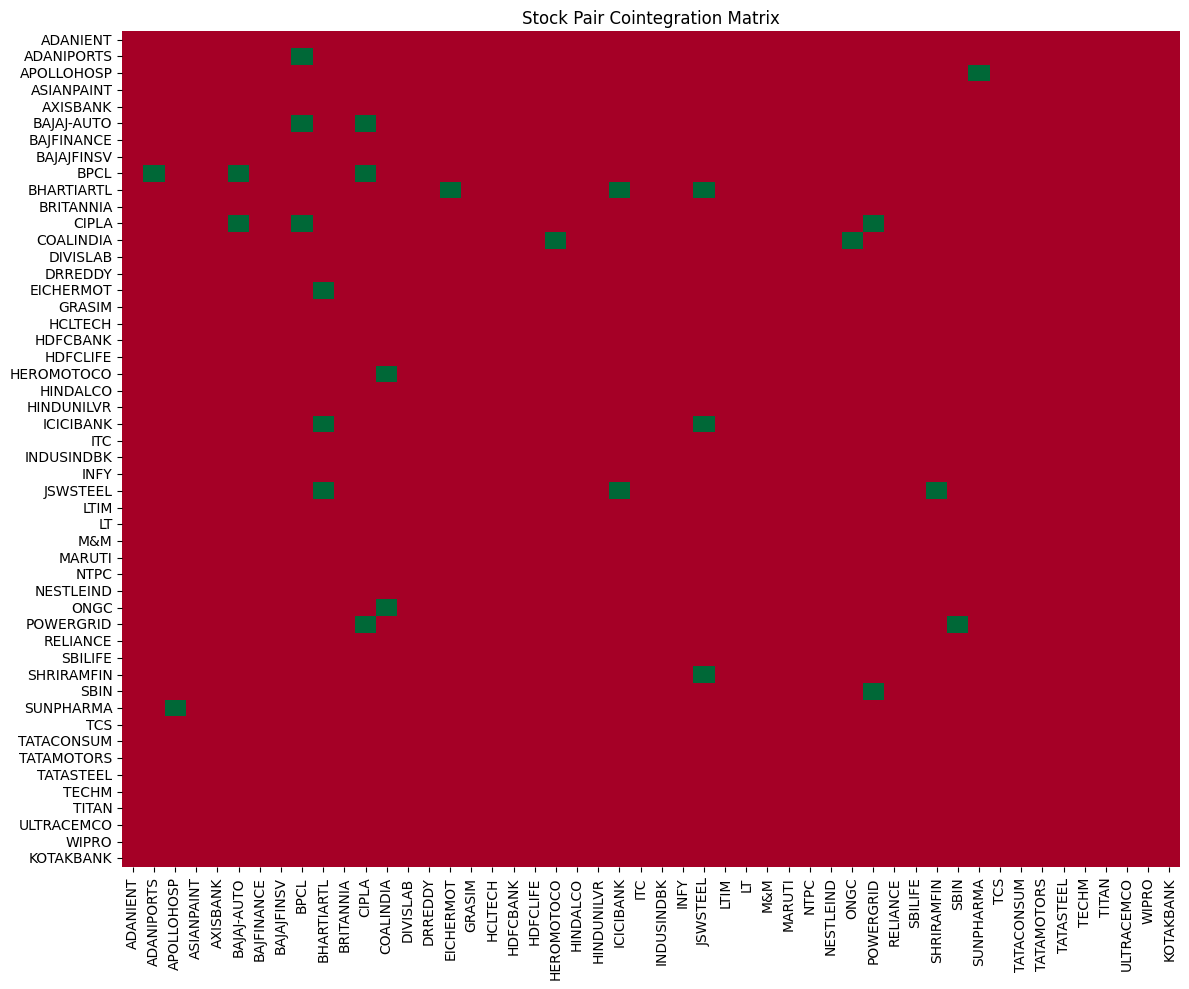

In [184]:
plt.figure(figsize=(12, 10))
sns.heatmap(bool_matrix, cmap='RdYlGn', cbar=False)
plt.title('Stock Pair Cointegration Matrix')
plt.tight_layout()
plt.show()

In [185]:
list_of_pairs

[{'ADANIPORTS', 'BPCL'},
 {'APOLLOHOSP', 'SUNPHARMA'},
 {'BAJAJ-AUTO', 'BPCL'},
 {'BAJAJ-AUTO', 'CIPLA'},
 {'BPCL', 'CIPLA'},
 {'BHARTIARTL', 'EICHERMOT'},
 {'BHARTIARTL', 'ICICIBANK'},
 {'BHARTIARTL', 'JSWSTEEL'},
 {'CIPLA', 'POWERGRID'},
 {'COALINDIA', 'HEROMOTOCO'},
 {'COALINDIA', 'ONGC'},
 {'ICICIBANK', 'JSWSTEEL'},
 {'JSWSTEEL', 'SHRIRAMFIN'},
 {'POWERGRID', 'SBIN'}]

APOLLOHOSP – SUNPHARMA
BAJAJ-AUTO – HEROMOTOCO (via COALINDIA)
BPCL – ONGC (via COALINDIA)
COALINDIA – ONGC
ICICIBANK – SBIN (via POWERGRID)

In [186]:
print(stock_filter('APOLLOHOSP', 'SUNPHARMA', test_data, 0.05, 0.8, True))
print(stock_filter('BAJAJ-AUTO', 'HEROMOTOCO', test_data, 0.1, 0.5, True))
print(stock_filter('BPCL', 'ONGC', test_data, 0.05, 0.8, True))
print(stock_filter('COALINDIA', 'ONGC', test_data, 0.05, 0.8, True))
print(stock_filter('ICICIBANK', 'SBIN', test_data, 0.05, 0.8, True))

APOLLOHOSP SUNPHARMA pval:0.00018070064482917115 corr:0.9511524880563368
True
BAJAJ-AUTO HEROMOTOCO pval:0.2619939508525093 corr:0.8977068168150433
False
BPCL ONGC pval:0.013106085632012904 corr:0.9131050818520566
True
COALINDIA ONGC pval:0.0068455547999032255 corr:0.9391462321903824
True
ICICIBANK SBIN pval:0.8826708492791695 corr:0.7764773999833228
False


APOLLOHOSP – SUNPHARMA
BPCL – ONGC
COALINDIA – ONGC

In [187]:
def e_t(ticker1, ticker2, data):
    S1 = data[ticker1]
    S2 = data[ticker2]
    X = sm.add_constant(S2)
    model = sm.OLS(S1, X).fit()
    residuals = model.resid
    return residuals[-1]

In [188]:
e_t('APOLLOHOSP', 'SUNPHARMA', data)

-71.05326938076814

In [196]:
t_values = range(0, len(data) - int(len(data)*0.7))
et_values = []
dates = []

for t in t_values:
    et_values.append(e_t('APOLLOHOSP','SUNPHARMA', data[:int(len(data)*0.7) + t]))
    dates.append(data[:int(len(data)*0.7) + t].index[-1])

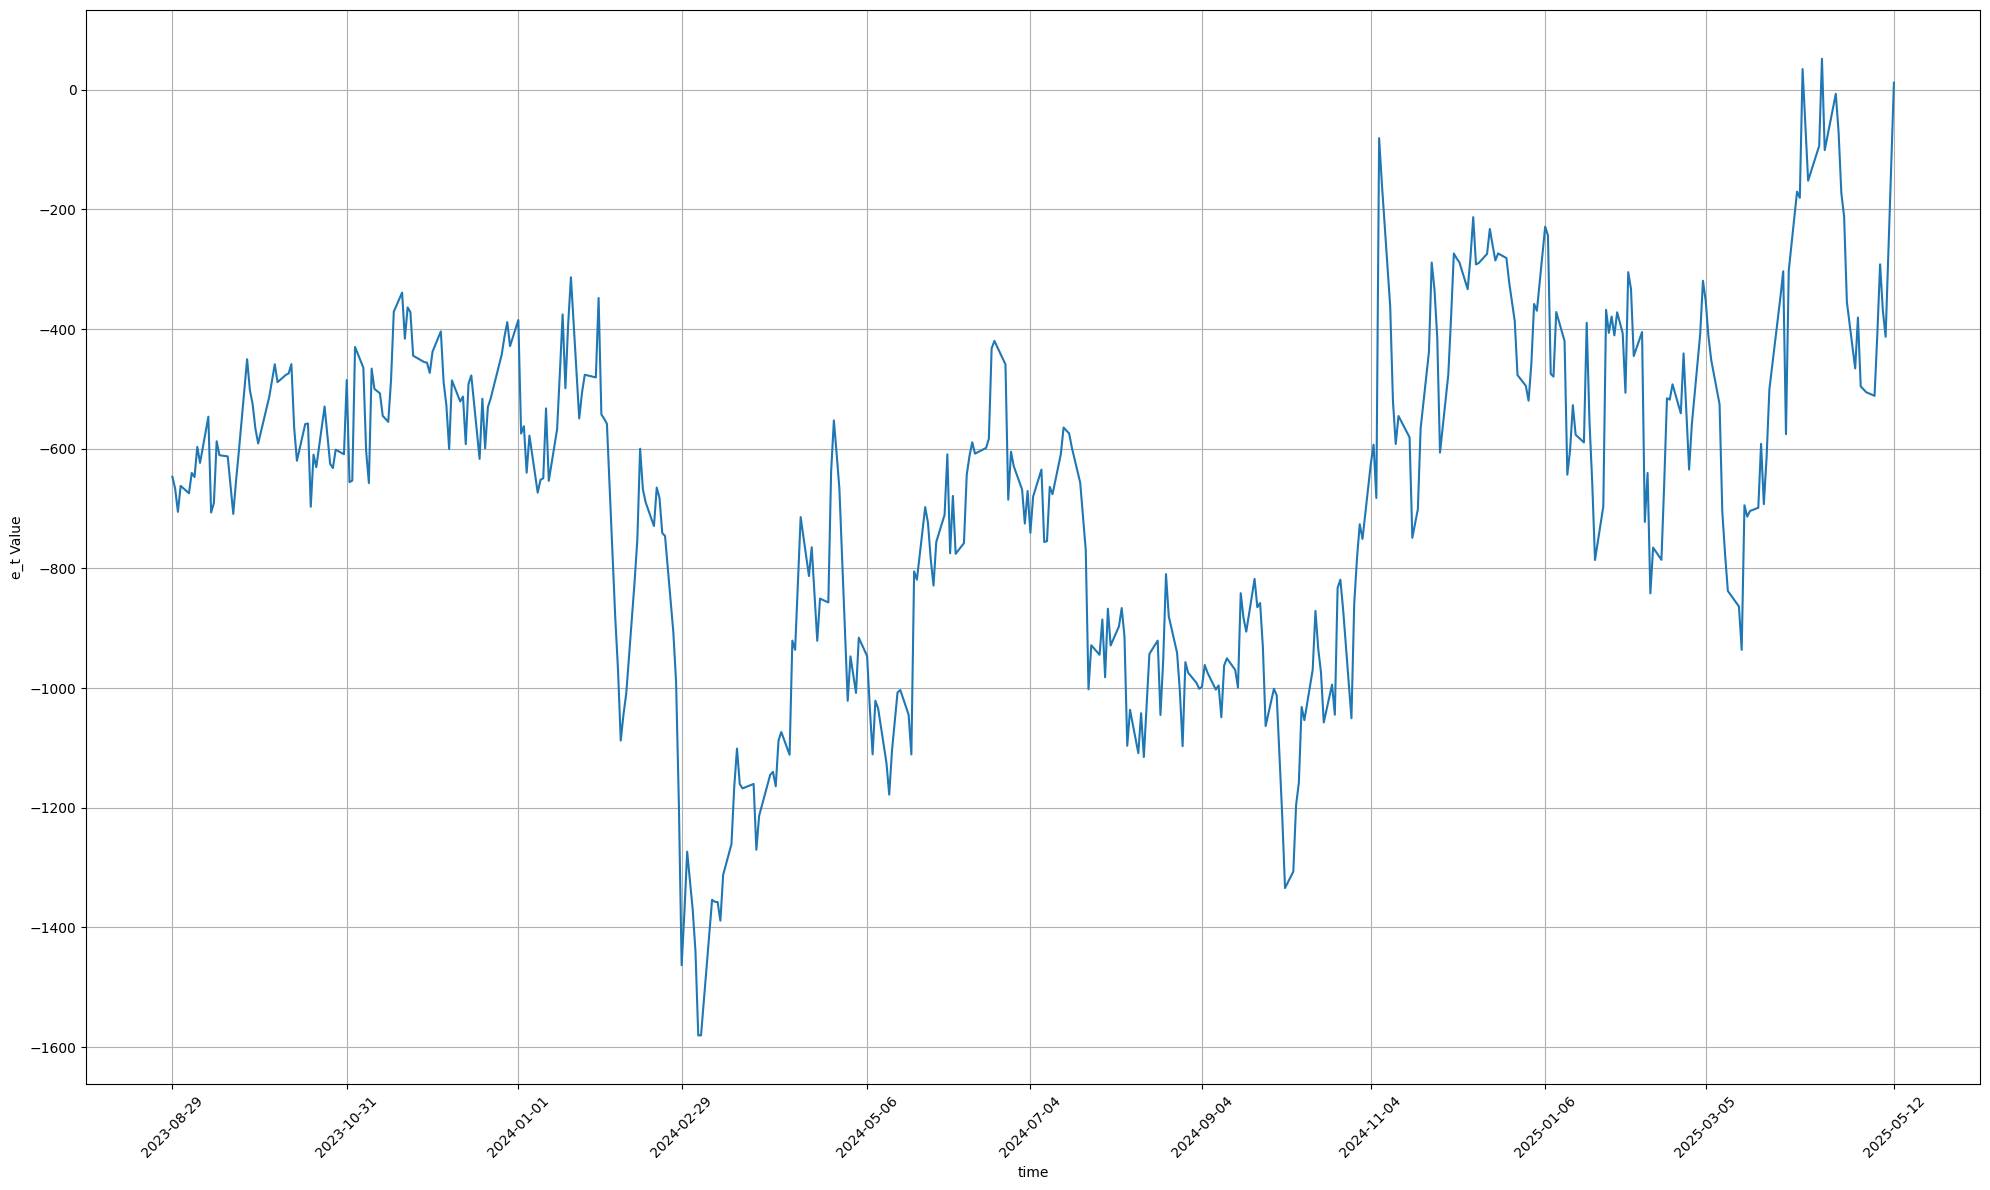

In [197]:
plt.figure(figsize=(20, 12))
plt.plot(dates, et_values)
plt.xlabel('time')
plt.ylabel('e_t Value')
plt.grid(True)
plt.xticks(rotation=45)
plt.xticks(dates[::len(dates)//10])
plt.tight_layout()
plt.show()

long apollo short sun farma 24-01-01, rev 24-02-29, rev 24-07-04, rev 2024-10-15, rev 24-11-04, rev 25-03-05